In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools

# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2018

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matematicos para aproximar una funcion de valor.

Ventajas:
* Permite trabajar con grandes espacios de estados al hacer uso de generalización.
* Permite trabajar con espacio de estados continuos.

Problemas:
* Aproximación de objetivos no estacionarios (nononstationarity reward) y con retardo (delayed reward).
* Bootstrapping

## CartPole: Agente aleatorio
CartPole es un entorno donde un poste está unido por una unión no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanezca en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve más de 2.4 unidades desde el centro.

In [2]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementacion de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Hay un gran problema con el uso de aproximadores para la funcion de valor $Q$. Las transiciones están muy correlacionadas. Esto reduce la varianza general de cada transición. Ya que toda la experiencia es extraida del mismo episodio (del actual). 

Imaginemos que tuvieramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

El equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en memoria y despues de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria de experiencia.

In [3]:
from agents.cart_pole_approx_vf import CartPole_SGD

agent = CartPole_SGD.SGDCartPoleSolver()
scores_SGD = agent.run()

[2018-09-25 12:10:26,508] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 10.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.0 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 15.83 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 12.64 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 11.45 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 11.06 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 11.48 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 10.73 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 10.69 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 10.46 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 10.05 ticks.


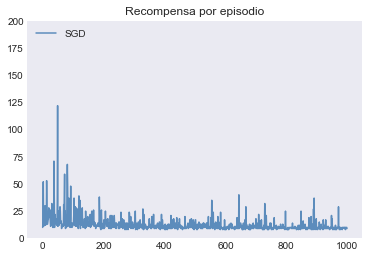

In [4]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

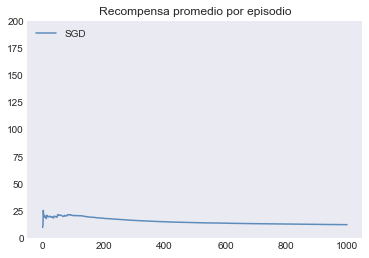

In [5]:
# se suaviza la curva de convergencia
def avg_reward(scores):
    episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
    acumulated_rewards = np.cumsum(scores)
    return [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

reward_per_episode_SGD = avg_reward(scores_SGD)

plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo que tiene estados con dos dimensiones númericas. Para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$. Se puede elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$, pero así, no se puede tener en cuenta ninguna interacción entre estas dimensiones. Además, si tanto $s_1$ como $s_2$ son cero, entonces el valor aproximado también será cero ($x(s)=0$). Ambas limitaciones se pueden superar representando $s$ por el vector de features polinomico $x(s)=(1,s_1,s_2,s_1s_2)$. El 1 inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s1s2$, permite que se tengan en cuenta dichas interacciones. Tambien se puede utilizar un vector de features polinomico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciónes mas complejas.

In [6]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly

agent = CartPole_SGD_Poly.SGDPolyCartPoleSolver()
scores_SGD_Poly = agent.run()

[2018-09-25 12:11:03,683] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 21.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 22.12 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 22.47 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 16.76 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 19.31 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 22.38 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 18.57 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 21.72 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 23.45 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 23.45 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 24.19 ticks.


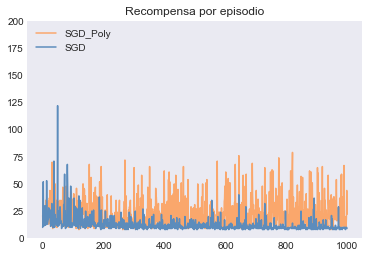

In [7]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

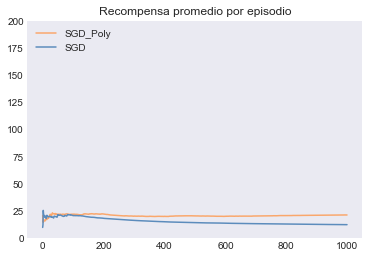

In [8]:
reward_per_episode_SGD_Poly = avg_reward(scores_SGD_Poly)

plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación actual ($w_{t}$). Donde el objetivo ($w_{t+1}$), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_{t}$ complica el proceso en comparación con la situación más simple de aprendizaje supervisado, en la que los objetivos no dependen de los parámetros que se actualizan. Esto puede conducir a oscilaciones y/o divergencia.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solucion para acercar el proceso de actualización de los parametros ($w_t$) de un estimador, al caso mas simple utilizado en aprendizaje supervisado. Esto es, cada vez que se realizan un cierto número, $C$, de actualizaciones de los pesos $w$ en el predictor, se realiza una copia de los mismos en otro modelo (Modelo Duplicado), donde se mantienen estos pesos duplicados de forma fija para las próximas $C$ actualizaciones de $w$. Las estimaciones de este modelo duplicado, se utilizan como objetivo en la actualizacion de los pesos $w$, en las próximas $C$ actualizaciones:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [9]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly_Dual

agent = CartPole_SGD_Poly_Dual.SGDPolyDualCartPoleSolver()
scores_SGD_Poly_Dual = agent.run()

[2018-09-25 12:17:40,603] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 35.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 25.79 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 31.47 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 62.61 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 104.01 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 147.96 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 162.24 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 160.0 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 154.5 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 155.17 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 158.35 ticks.


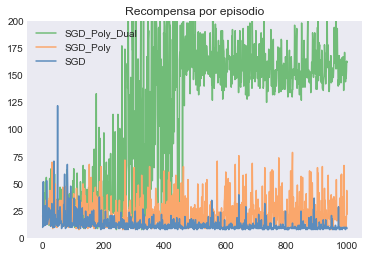

In [10]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

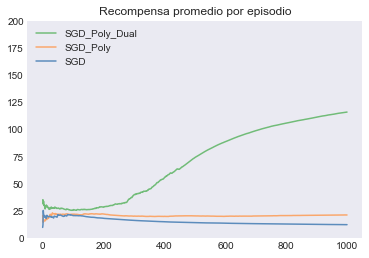

In [11]:
reward_per_episode_SGD_Poly_Dual = avg_reward(scores_SGD_Poly_Dual)
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales
Como ultima mejora, vamos a reemplazar el aproximador lineal por una red neuronal. En este caso, como estamos trabajando con un entorno donde directamente el agente percive los features que representan el estado del mismo. En otras palabras, como nuestro agente no percive el estado del entorno a traves de una sucesion de imagenes, no es necesario que nuestra red cuente con capas convolucionales que generen features del entorno. Por lo tanto, utilizaremos una red neuronal 'fully connected' de 3 capas con la siguiente arquitectura:

![nn_dense](images/nn_dense.png)

En este caso, como el aproximador usado es 'no lineal', no tenemos necesidad de hacer un preprosesamiento de los features, como en el caso del agente 'SGD_Poly' y 'SGD_Poly_Dual', para poder capturar las relaciónes no lineales entre los distintos features del entorno.

### Funciones de activación:
![activation_functions](images/activation_functions.png)

In [ ]:
from agents.cart_pole_approx_vf import CartPole_DQN

agent = CartPole_DQN.DQNCartPoleSolver()
scores_DQN = agent.run()

Using TensorFlow backend.
[2018-09-25 12:53:39,166] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 17.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 35.35 ticks.


In [ ]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DQN))), np.array(scores_DQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

In [ ]:
reward_per_episode_DQN = avg_reward(scores)
plt.plot(reward_per_episode_DQN, label='DQN', c='#7e5fa4')
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Ejercicios Lab Final

Se pide:

1) Dado el agente que utiliza una red neuronal para aproximar la funcion de valor, modificar la arquitectura de la misma en busca de una mejora en el desempeño del agente. La modificaciones a realizar puede ser:
    * Agregar mas capas ocultas a la red
    * Modificar las funciones de activacion de las neuronas
    * Modificar el numero de neuronas en cada capa
    
**Recomendación #1**: Tener en cuenta que al incorporar mas capas y neuronas a una red neuronal, mas complejidad computacional se incorpora al modelo, lo que se traduce en una mayor duración (en tiempo) del entrenamiento del agente.

**Recomendación #2**: Una métrica eficiente para comparar del desempeño de diferentes agentes es la curva de "reward promedio acumulado". Esta metrica permite visualizar el desempeño general del agente, como asi tambien la rapidez (cantidad de episodios) que requiere un agente para alcanzar un determinado desempeño. 

**Recomendación #3**: Al modificar distintos aspecto de la arquitectura del aproximador, realizar de a un cambio por evaluación.

2) Adaptar los agentes implementados en el notebook (incluido el implementado por ustedes) al entorno 'MountainCar-v0' (http://gym.openai.com/envs/MountainCar-v0/) y comparar el desempeño de los mismos.

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo Pycharm, debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.